In [42]:
import numpy as np
import matplotlib.pyplot as plt

In [30]:
class non_stat_env:
  def __init__(self, n_arms, probs_matrix, horizon):
    self.n_arms = n_arms
    self.probs_matrix = probs_matrix
    self.horizon = horizon
    self.n_changes = len(probs_matrix)
    self.inner_horizon = self.horizon // self.n_changes
    self.t = 0
    self.phase = 0

  def round(self, pulled_arm):
    if self.t > (self.phase + 1)*self.inner_horizon:
      self.phase = min(self.phase+1, self.n_changes-1)
    reward = np.random.binomial(n=1, p=self.probs_matrix[self.phase, pulled_arm])
    self.t += 1
    return reward

In [31]:
class learner:
  def __init__(self, n_arms):
    self.t = 0
    self.n_arms = n_arms
    self.reward = []
    self.reward_per_arm = [[] for _ in range(n_arms)]
    self.pulled = []

  def act(self):
    pass

  def update(self, arm_pulled, reward):
    self.t += 1
    self.reward.append(reward)
    self.reward_per_arm[arm_pulled].append(reward)
    self.pulled.append(arm_pulled)

In [35]:
class SW_TS(learner):
  def __init__(self, n_arms, windows_size):
    super().__init__(n_arms)
    self.n_arms = n_arms
    self.window_size = windows_size
    self.alphas = np.ones(self.n_arms)
    self.betas = np.ones(self.n_arms)
    self.t = 0
  
  def reset(self):
    self.__init__(self.n_arms, self.window_size)

  def update(self, pulled_arm, reward):
      super().update(pulled_arm, reward)
      for arm_idx in range(self.n_arms):
        n_samples = np.sum(np.array(self.pulled[-self.window_size:])==arm_idx)
        if n_samples == 0:
          n_sold = 0
        else: 
          n_sold = np.sum(self.reward_per_arm[arm_idx][-n_samples:])
        self.alphas[arm_idx] = n_sold + 1 
        self.betas[arm_idx] = n_samples - n_sold + 1 
        assert self.betas[arm_idx]>0, (arm_idx, self.pulled[-self.window_size:], n_sold)

  def act(self):
    samples = [np.random.beta(a = self.alphas[i],b = self.betas[i]) for i in range(self.n_arms)]
    return np.argmax(samples)

In [40]:
p = np.array([[0.5, 0.4, 0.3, 0.2], 
              [0.4, 0.5, 0.2, 0.3], 
              [0.3, 0.2, 0.4, 0.6]])


T = 1000
n_arms = p.shape[1]
env = non_stat_env(n_arms, p, T)
windows_size = 4*int(np.sqrt(T))
ag1 = SW_TS(n_arms, windows_size)
opt = np.max(p, axis =1)
N_exp = 5
R = []

for _ in range(N_exp):
    instant_regret = []
    ag1.reset()
    for t in range(T):
        pulled_arm = ag1.act()
        rew = env.round(pulled_arm)
        ag1.update(pulled_arm, rew)
        phase = env.phase
        instant_regret.append(opt[phase]-p[phase, pulled_arm])
        #instant_regret.append(opt[phase]-rew)
    cumulative_regert = np.cumsum(instant_regret)
    R.append(cumulative_regert)
mean_R = np.mean(R, axis=0)
std_dev = np.std(R, axis=0)/np.sqrt(N_exp)

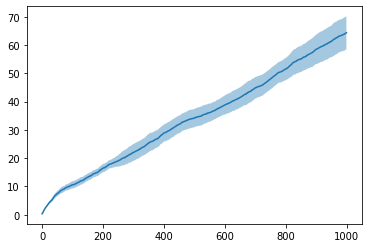

In [41]:
plt.plot(mean_R)
plt.fill_between(range(T), mean_R-std_dev, mean_R+std_dev, alpha=0.4)